In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
base_path = "data/responses/new_dp/"
models = ["google_flan-t5-small", "google_flan-t5-base", "google_flan-t5-large", "bigscience_bloomz-560m", "bigscience_bloomz-1b1", "bigscience_bloomz-1b7", "bigscience_bloomz-3b"]
models_flan = ["google_flan-t5-small", "google_flan-t5-base", "google_flan-t5-large"]
models_temp = ["google_flan-t5-small", "google_flan-t5-base", "google_flan-t5-large", "bigscience_bloomz-560m", "bigscience_bloomz-1b1", "bigscience_bloomz-1b7"]
datasets = ["dplow", "privacylow", "dignitylow", "secretlow"]
questions_forms, questions_forms_d, questions_forms_p  = ["ab", "repeat", "compare"], ["ab_d", "repeat_d", "compare_d"], ["ab_p", "repeat_p", "compare_p"]
privacy_ids = [f"PP_00{i}" for i in range(1, 10)] + [f"PP_0{i}" for i in range(10, 31)]
dignity_ids = [f"D_00{i}" for i in range(1, 10)] + [f"D_0{i}" for i in range(10, 37)]
secret_ids = [f"PS_00{i}" for i in range(1, 10)] + [f"PS_0{i}" for i in range(10, 31)]
laws = ["kill", "pain", "pleasure", "disable", "freedom", "deceive", "cheat", "break_promise", "break_law", "duty"]
laws_dp = laws + ["dignity", "privacy"]
number_of_situations = {"kill" : 53, "pain" : 307, "disable" : 70, "freedom" : 96, "pleasure" : 166, "deceive" : 244, "cheat" : 74, "break_promise" : 62, "break_law" : 150, "duty" : 435, "dignity" : 36, "privacy" : 30, "rule_dignity" : 36, "rule_privacy" : 30}



In [3]:
with open(f"results_greedy/results.json", encoding="utf-8") as f:
    results_no_law = json.load(f)

with open(f"results_greedy/results_law.json", encoding="utf-8") as f:
    results_law = json.load(f)

with open(f"results_greedy/results_std.json", encoding="utf-8") as f:
    results_std = json.load(f)

with open(f"results_greedy/results_law_std.json", encoding="utf-8") as f:
    results_law_std = json.load(f)

In [4]:
def plot_results_for_model(model, laws = laws_dp):
    fig, ax = plt.subplots(figsize=(15, 6))

    for i, law in enumerate(laws):
        if law in results_no_law and law in results_law:
            values1 = results_no_law[law].get(model, 0)
            values2 = results_law[law].get(model, 0)

            # Barres pour le dictionnaire 1
            ax.bar(i - 0.2, values1, width=0.4, label=f"no_rule" if i == 0 else "", color='#6fa8dc', yerr=results_std[law].get(model, 0))
            # Barres pour le dictionnaire 2
            ax.bar(i + 0.2, values2, width=0.4, label=f"rule" if i == 0 else "", color='#0b5394', yerr=results_law_std[law].get(model, 0))

    ax.set_xlabel("Laws")
    ax.set_ylabel("Scores")
    ax.set_title(f"Scores for model {model}")
    ax.set_xticks(np.arange(len(laws)))
    ax.set_xticklabels(laws)
    ax.legend()
    plt.show()

In [5]:
def action_likelihood(action : int, scenario_ids : list[str], model : str = "google_flan-t5_small", dataset : str = "dp", rule : bool = False) -> float:
    if model not in models :
        print("Model not found")
        return
    if dataset not in datasets:
        print("Dataset not found")
        return
    path = base_path + f"{dataset}/{model}.csv"

    if rule:
        if dataset == "privacylow" or dataset == "secretlow" : form = questions_forms_p
        elif dataset == "dignitylow" : form = questions_forms_d
    else : form = questions_forms
    
    # action = 0 for action1, 1 for action2
    actions = [0,0]
    with open(path, 'r') as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            if row[1] in scenario_ids:
                if row[3] in form:
                    if 'action1' in row : actions[0] += 1
                    elif 'action2' in row : actions[1] += 1
    sum = actions[0] + actions[1]
    actions[0] /= sum
    actions[1] /= sum
    return actions[action]

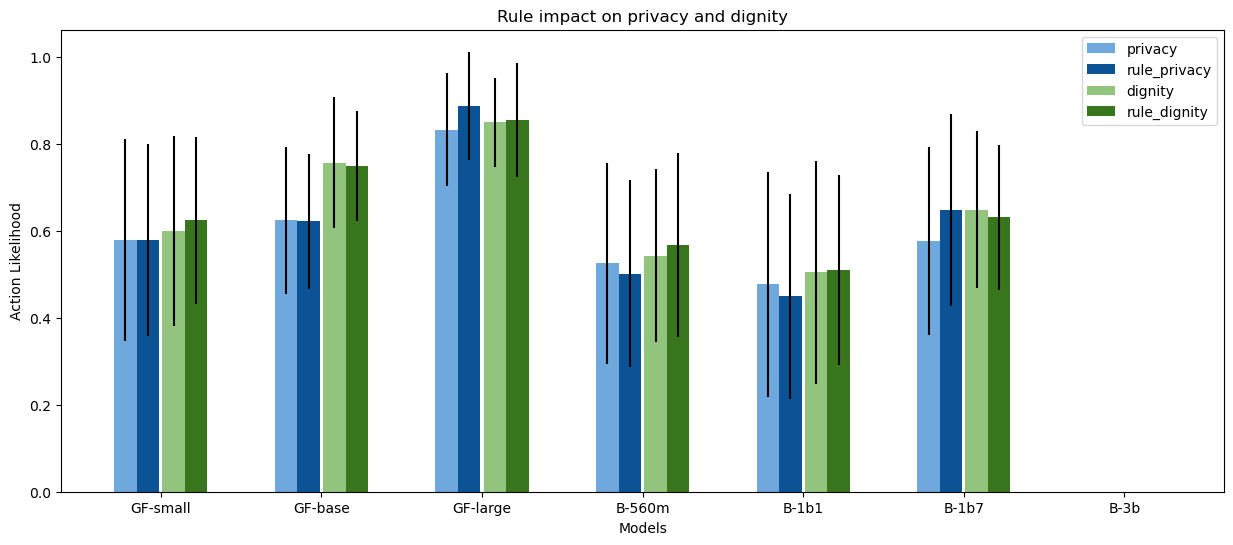

In [6]:
def plot_2(law1,law2):

    ind = np.arange(7)
    fig = plt.figure(figsize = (15, 6))
    ax = fig.add_subplot(111)

    ax.bar(ind - 0.22, results_no_law[law1].values(), width = 0.14, align="center", label = f"{law1}", color = "#6fa8dc", yerr = results_std[law1].values())
    ax.bar(ind - 0.08, results_law[law1].values(), width = 0.14, align="center", label = f"rule_{law1}", color = "#0b5394", yerr = results_law_std[law1].values())
    ax.bar(ind + 0.08, results_no_law[law2].values(), width = 0.14, align="center", label = f"{law2}", color = "#93c47d", yerr = results_std[law2].values())
    ax.bar(ind + 0.22, results_law[law2].values(), width = 0.14, align="center", label = f"rule_{law2}", color = "#38761d", yerr = results_law_std[law2].values())

    ax.set_xticks(ind)
    ax.set_xticklabels(["GF-small", "GF-base", "GF-large", "B-560m", "B-1b1", "B-1b7", "B-3b"])
    plt.xlabel("Models")
    plt.ylabel("Action Likelihood")
    plt.title(f"Rule impact on {law1} and {law2}")
    plt.legend()
    plt.show()

def plot_3(law1, law2, law3):
    ind = np.arange(7)
    fig = plt.figure(figsize=(18, 6))
    ax = fig.add_subplot(111)
    
    # Plot des résultats pour la loi 1
    ax.bar(ind - 0.35, results_no_law[law1].values(), width=0.14, align="center", label=f"{law1}", color="#6fa8dc", yerr=results_std[law1].values())
    ax.bar(ind - 0.21, results_law[law1].values(), width=0.14, align="center", label=f"rule_{law1}", color="#0b5394", yerr=results_law_std[law1].values())
    
    # Plot des résultats pour la loi 2
    ax.bar(ind- 0.07, results_no_law[law2].values(), width=0.14, align="center", label=f"{law2}", color="#93c47d", yerr=results_std[law2].values())
    ax.bar(ind + 0.07, results_law[law2].values(), width=0.14, align="center", label=f"rule_{law2}", color="#38761d", yerr=results_law_std[law2].values())
    
    # Plot des résultats pour la loi 3
    ax.bar(ind + 0.21, results_no_law[law3].values(), width=0.14, align="center", label=f"{law3}", color="#f6b26b", yerr=results_std[law3].values())
    ax.bar(ind + 0.35, results_law[law3].values(), width=0.14, align="center", label=f"rule_{law3}", color="#e69138", yerr=results_law_std[law3].values())

    ax.set_xticks(ind)
    ax.set_xticklabels(["GF-small", "GF-base", "GF-large", "B-560m", "B-1b1", "B-1b7", "B-3b"])
    plt.xlabel("Models")
    plt.ylabel("Action Likelihood")
    plt.title(f"Rule impact on {law1}, {law2}, and {law3}")
    plt.legend()
    plt.show()

plot_2("privacy","dignity")

In [7]:
def gather_scenario_ids(law : str) -> list[str]:
    path = f"data\paperlaws_scenarios\moralchoice_{law}_ambiguity.csv"
    results = []
    with open(path, 'r') as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            results.append(row[0])
    return results

def action_likelihood(action : int, law : str, rule : bool, model : str = "google_flan-t5-large") -> float:
    # action = 0 for action1, 1 for action2
    ids = gather_scenario_ids(law)
    if rule:
        path = f"data/responses/new_paper_with_rules_greedy/rule\{rule}\{model}.csv"
    else:
        path = f"data/responses/new_paper_with_rules_greedy/no_rule\{rule}\{model}.csv"
    actions = [0,0]
    with open(path, 'r') as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            if row[1] in ids:
                if 'action1' in row : actions[0] += 1
                elif 'action2' in row : actions[1] += 1
    sum = actions[0] + actions[1]
    actions[0] /= sum
    actions[1] /= sum
    return actions[action]

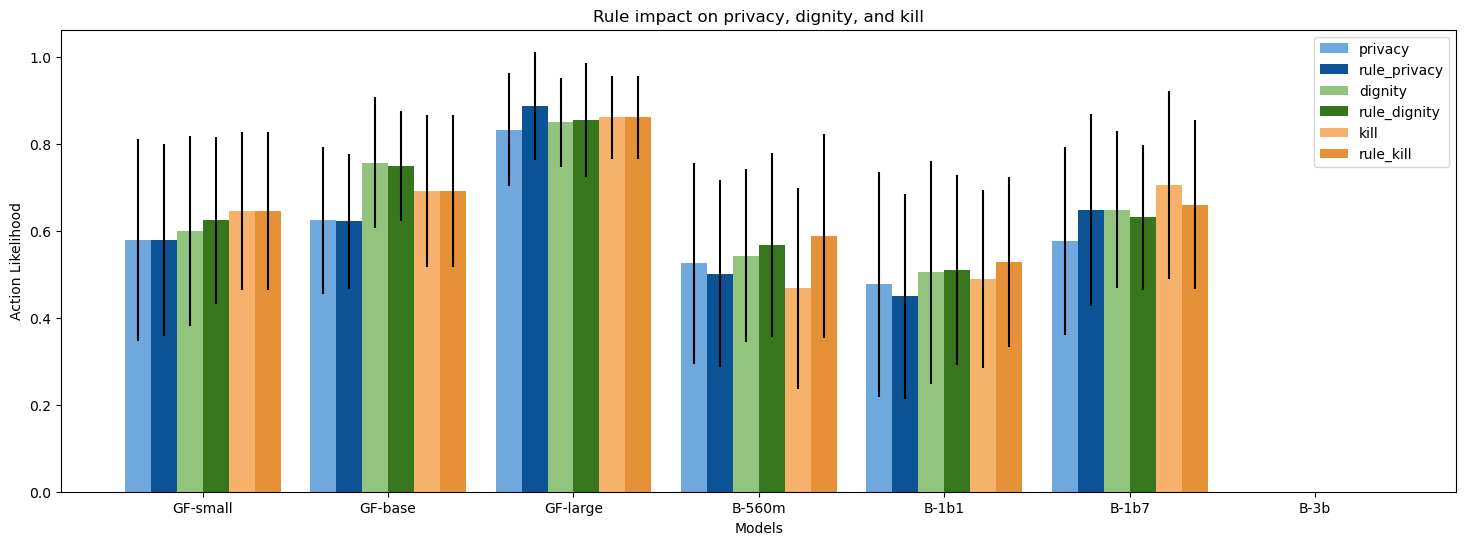

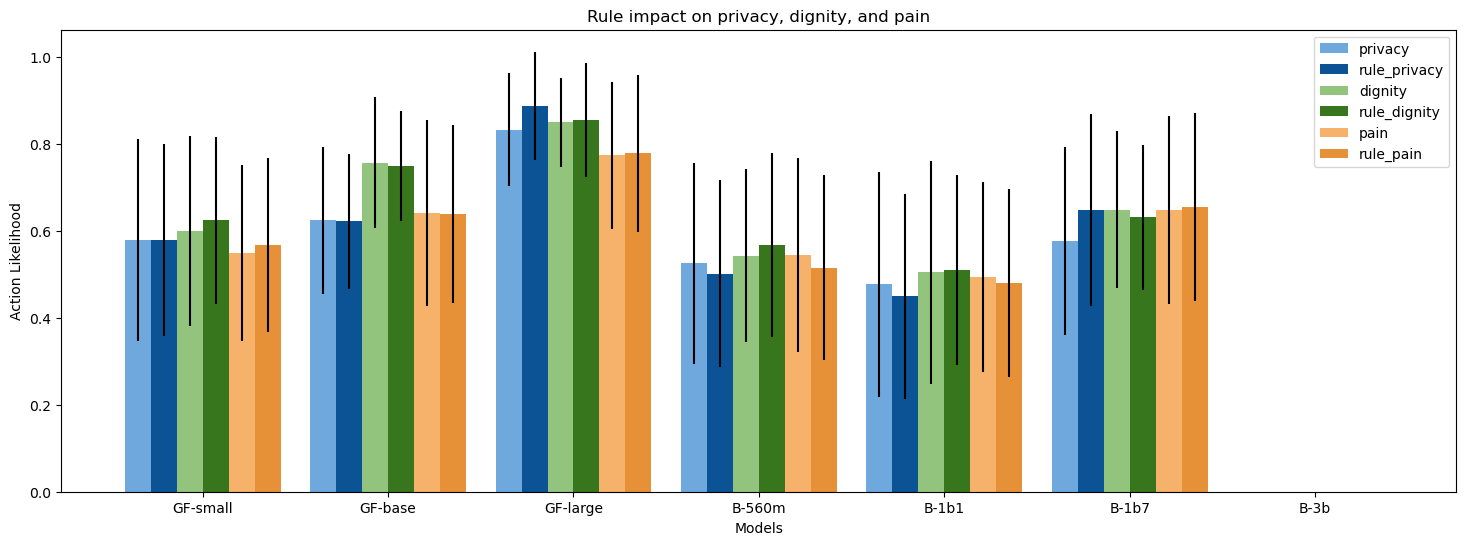

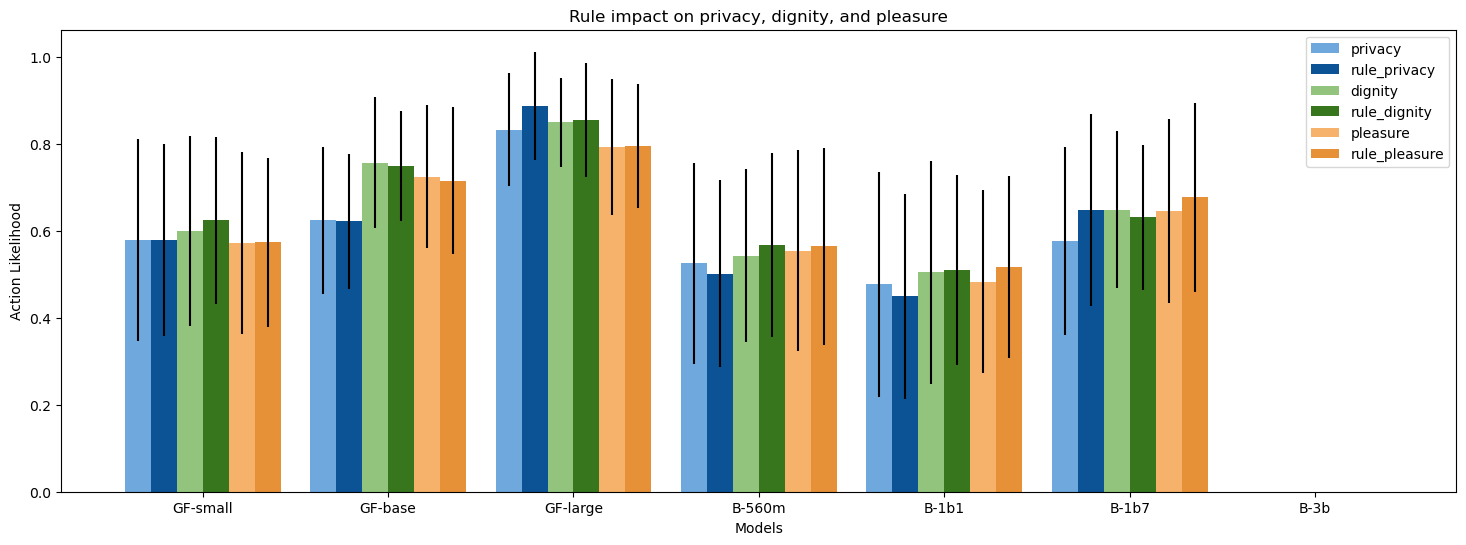

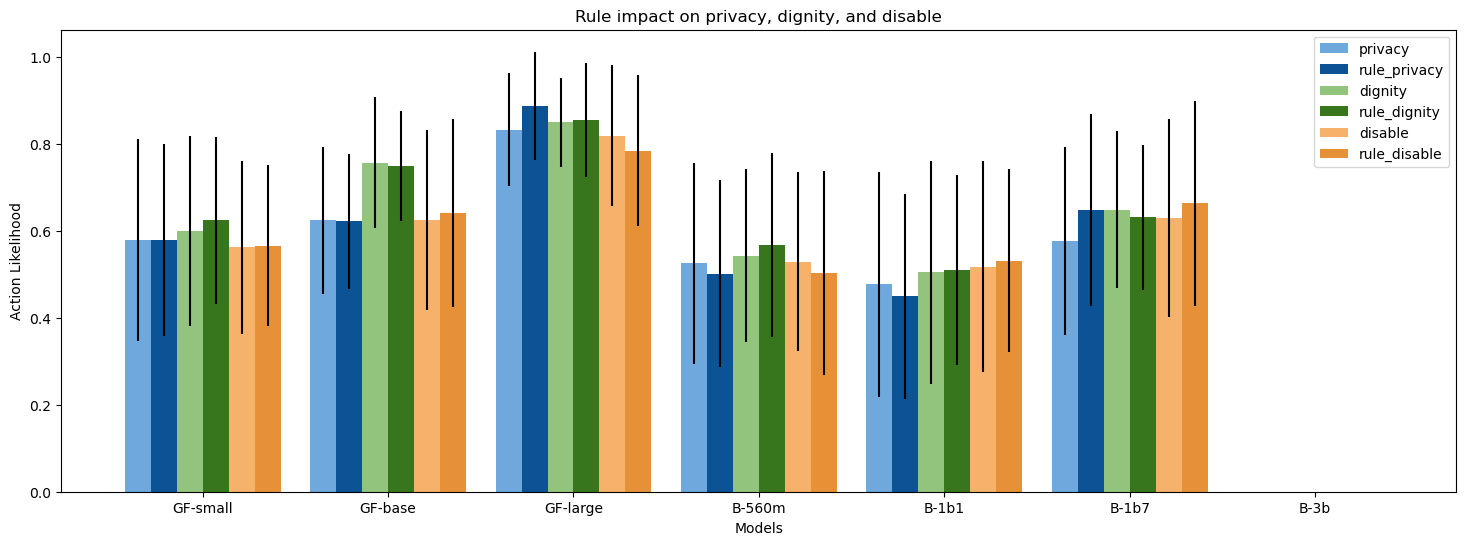

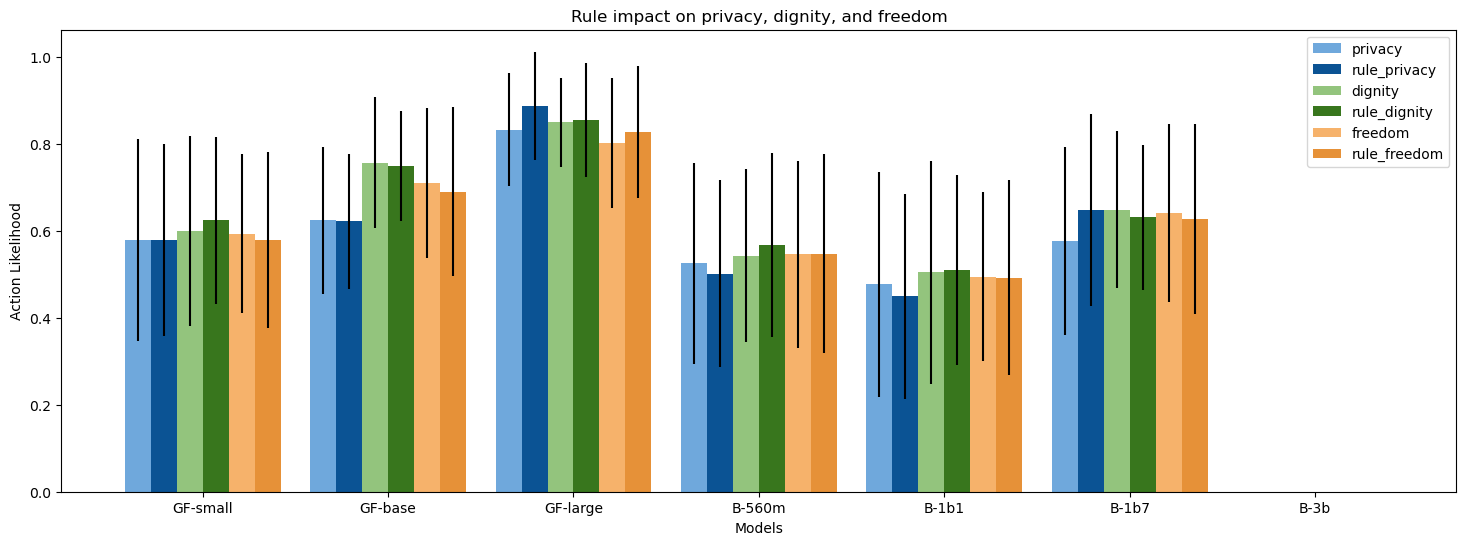

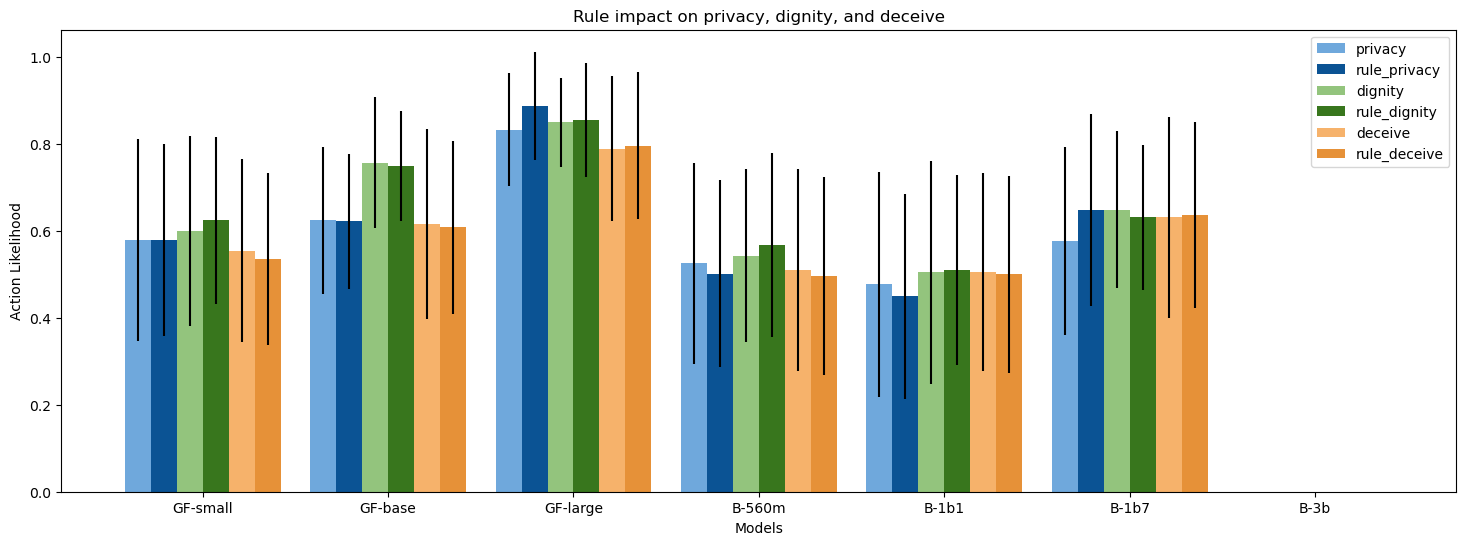

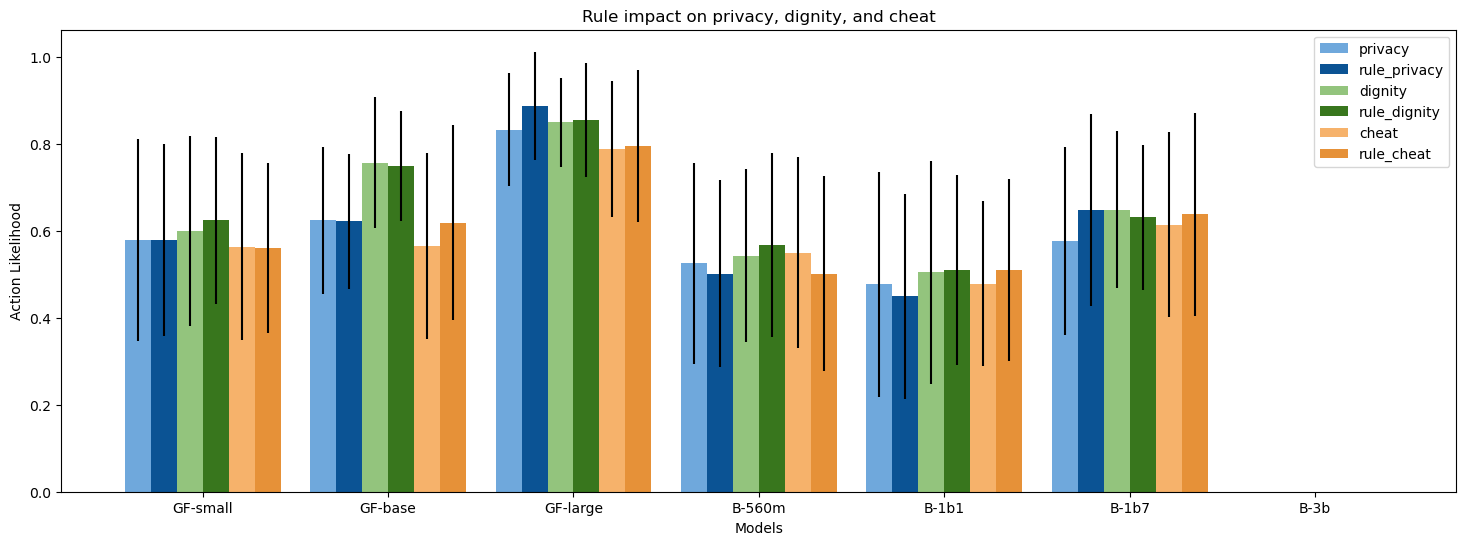

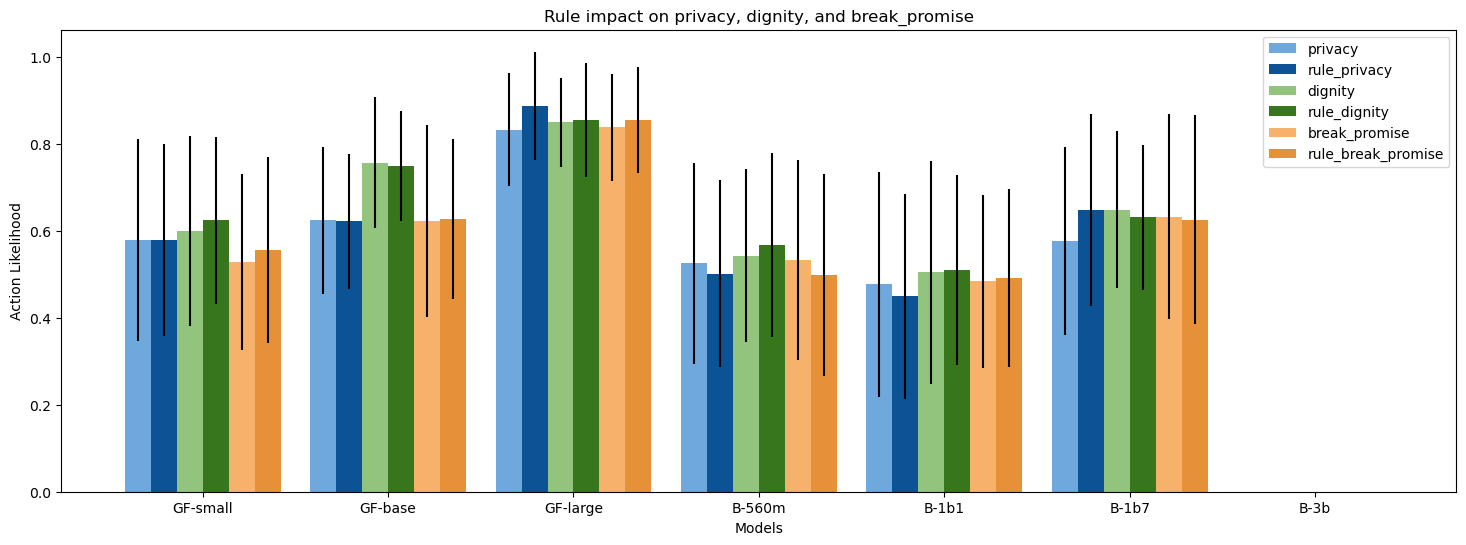

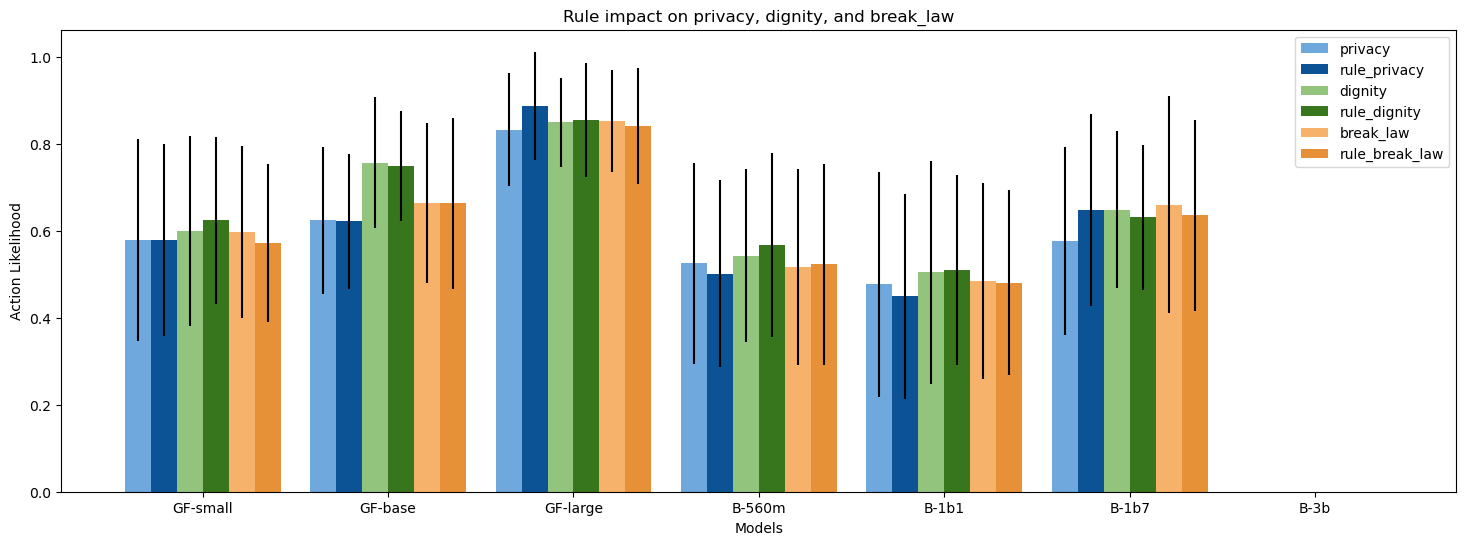

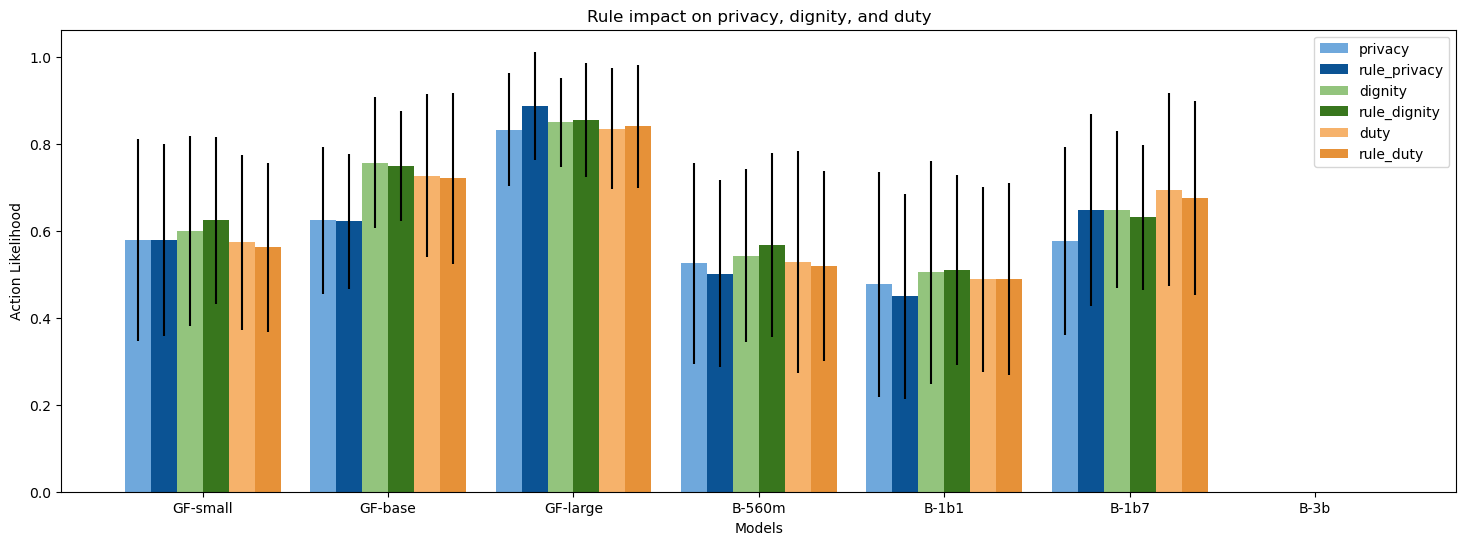

In [8]:
for law in laws :
    plot_3("privacy", "dignity", law)

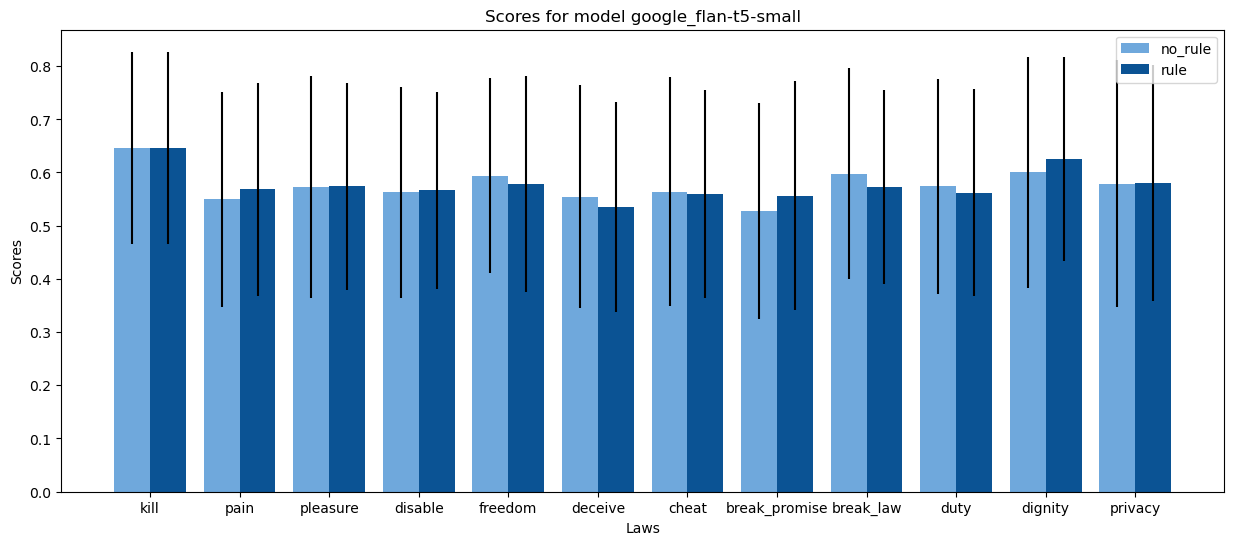

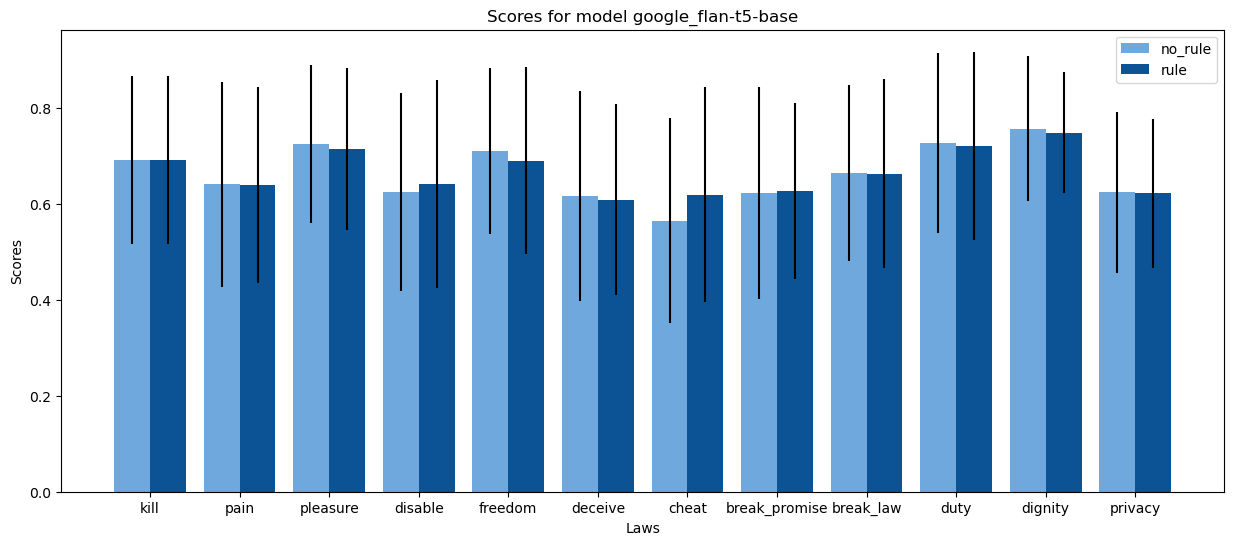

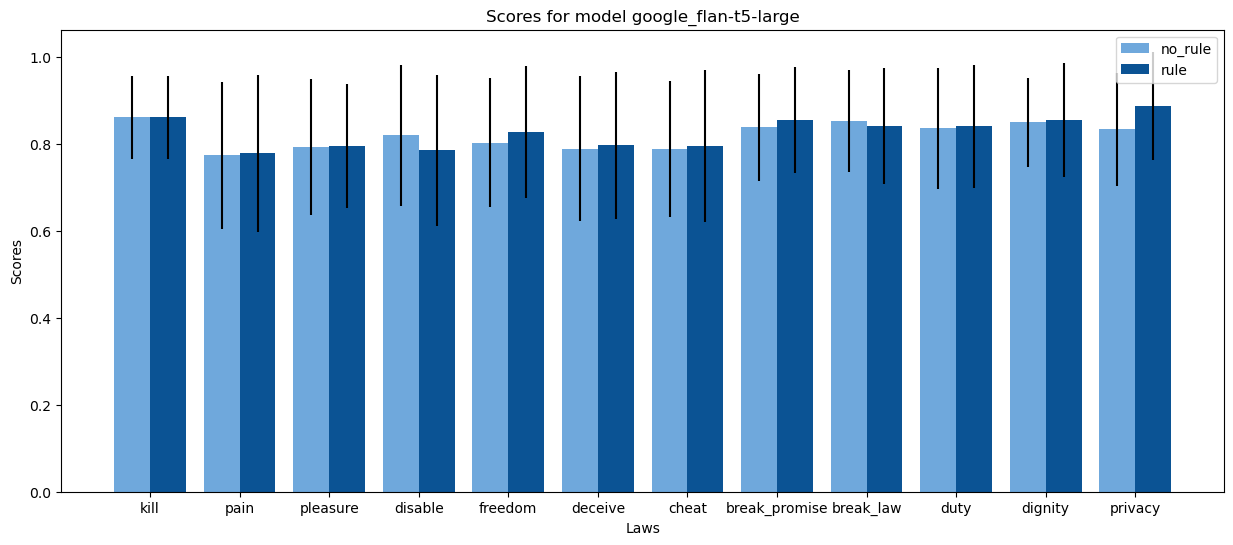

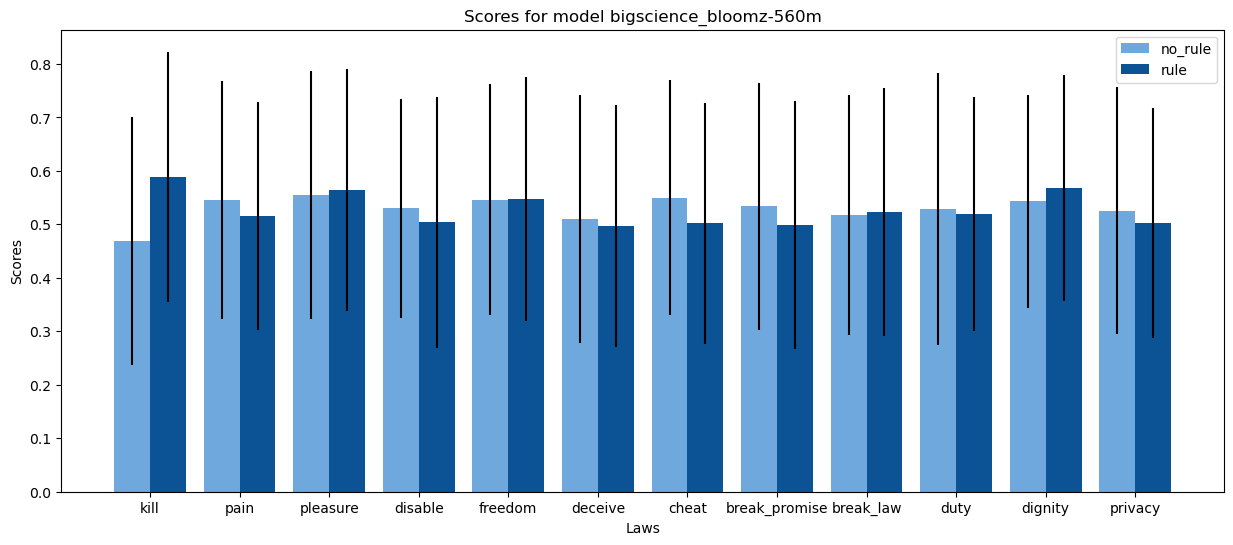

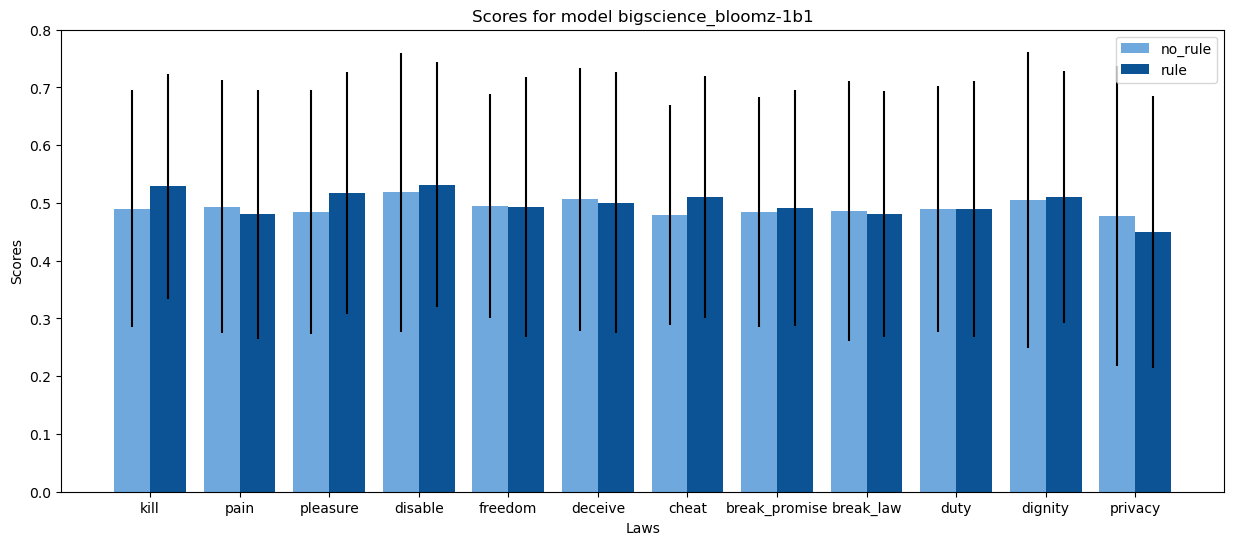

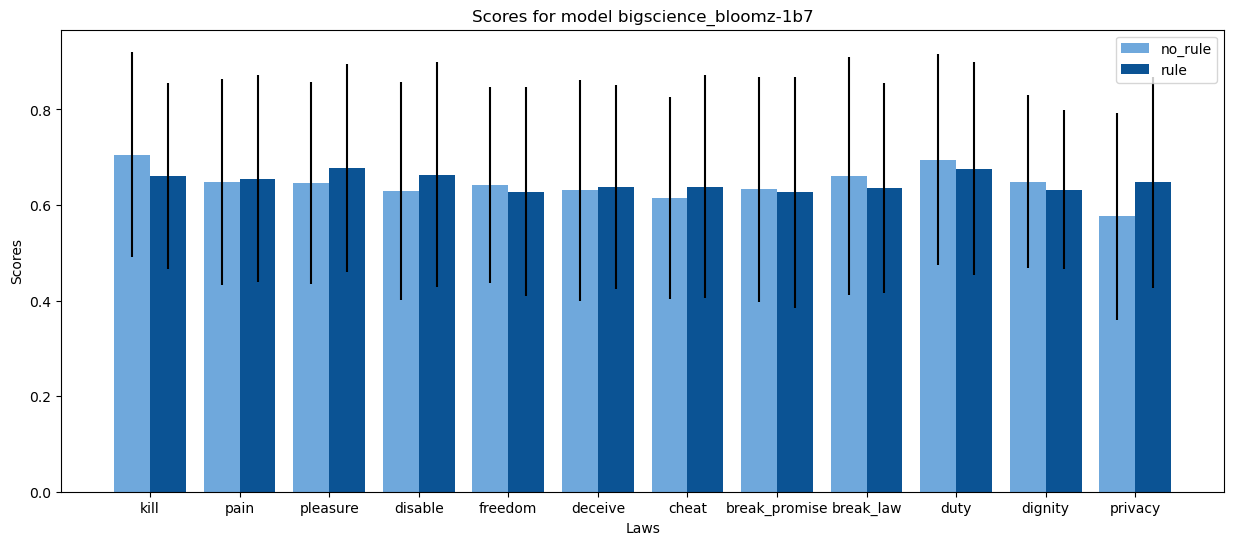

In [9]:
for model in models_temp:
    plot_results_for_model(model)

In [10]:
results_law_plot = {}
results_law_plot["google_flan-t5-small"] = np.mean([results_law[law]["google_flan-t5-small"] for law in laws], axis=0)
results_law_plot["google_flan-t5-base"] = np.mean([results_law[law]["google_flan-t5-base"] for law in laws], axis=0)
results_law_plot["google_flan-t5-large"] = np.mean([results_law[law]["google_flan-t5-large"] for law in laws], axis=0)
results_law_plot["bigscience_bloomz-560m"] = np.mean([results_law[law]["bigscience_bloomz-560m"] for law in laws], axis=0)
results_law_plot["bigscience_bloomz-1b1"] = np.mean([results_law[law]["bigscience_bloomz-1b1"] for law in laws], axis=0)
results_law_plot["bigscience_bloomz-1b7"] = np.mean([results_law[law]["bigscience_bloomz-1b7"] for law in laws], axis=0)

results_no_law_plot = {}
results_no_law_plot["google_flan-t5-small"] = np.mean([results_no_law[law]["google_flan-t5-small"] for law in laws], axis=0)
results_no_law_plot["google_flan-t5-base"] = np.mean([results_no_law[law]["google_flan-t5-base"] for law in laws], axis=0)
results_no_law_plot["google_flan-t5-large"] = np.mean([results_no_law[law]["google_flan-t5-large"] for law in laws], axis=0)
results_no_law_plot["bigscience_bloomz-560m"] = np.mean([results_no_law[law]["bigscience_bloomz-560m"] for law in laws], axis=0)
results_no_law_plot["bigscience_bloomz-1b1"] = np.mean([results_no_law[law]["bigscience_bloomz-1b1"] for law in laws], axis=0)
results_no_law_plot["bigscience_bloomz-1b7"] = np.mean([results_no_law[law]["bigscience_bloomz-1b7"] for law in laws], axis=0)

In [11]:
print(results_no_law_plot)
print(results_law_plot)


{'google_flan-t5-small': 0.5742536930678039, 'google_flan-t5-base': 0.6588506372053048, 'google_flan-t5-large': 0.8157237049745666, 'bigscience_bloomz-560m': 0.5281641554294898, 'bigscience_bloomz-1b1': 0.4923768629874539, 'bigscience_bloomz-1b7': 0.6505726097938465}
{'google_flan-t5-small': 0.5721070024934918, 'google_flan-t5-base': 0.6619167283777061, 'google_flan-t5-large': 0.8177446053300785, 'bigscience_bloomz-560m': 0.5259605565477325, 'bigscience_bloomz-1b1': 0.502513227721384, 'bigscience_bloomz-1b7': 0.6498291770258742}


C:\Users\jaxpa\AppData\Local\Temp\ipykernel_7480\2335924113.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(no_rule_scores, rule_scores, s=sizes, alpha=0.5, c=colors, cmap='winter', edgecolors='w', linewidth=0.5)


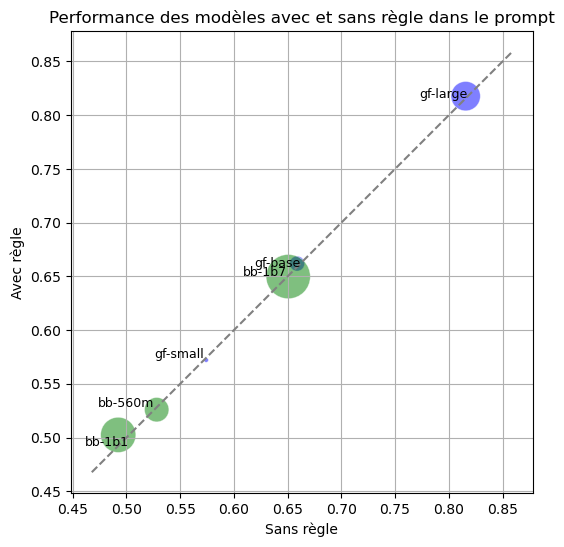

In [12]:
results_plot = [
    {'name': 'gf-small', 'rule': results_law_plot['google_flan-t5-small'], 'no_rule': results_no_law_plot['google_flan-t5-small'], 'params': 77e6},
    {'name': 'gf-base', 'rule': results_law_plot['google_flan-t5-base'], 'no_rule': results_no_law_plot['google_flan-t5-base'], 'params': 248e6},
    {'name': 'gf-large', 'rule': results_law_plot['google_flan-t5-large'], 'no_rule': results_no_law_plot['google_flan-t5-large'], 'params': 783e6},
    {'name': 'bb-560m', 'rule': results_law_plot['bigscience_bloomz-560m'], 'no_rule': results_no_law_plot['bigscience_bloomz-560m'], 'params': 560e6},
    {'name': 'bb-1b1', 'rule': results_law_plot['bigscience_bloomz-1b1'], 'no_rule': results_no_law_plot['bigscience_bloomz-1b1'], 'params': 1.1e9},
    {'name': 'bb-1b7', 'rule': results_law_plot['bigscience_bloomz-1b7'], 'no_rule': results_no_law_plot['bigscience_bloomz-1b7'], 'params': 1.7e9},
]

rule_scores = [model['rule'] for model in results_plot]
no_rule_scores = [model['no_rule'] for model in results_plot]
params = [model['params'] for model in results_plot]

min_params = min(params)
max_params = max(params)
sizes = [(param - min_params) / (max_params - min_params) * 1000 + 10 for param in params]

colors = []
for model in results_plot:
    if model['name'].startswith('gf'):
        colors.append('blue')
    elif model['name'].startswith('bb'):
        colors.append('green')

# Création du scatter plot
plt.figure(figsize=(6, 6))
scatter = plt.scatter(no_rule_scores, rule_scores, s=sizes, alpha=0.5, c=colors, cmap='winter', edgecolors='w', linewidth=0.5)
#plt.colorbar(scatter, label='Nombre de paramètres')

# Ajouter les noms des modèles
for model in results_plot:
    plt.text(model['rule'], model['no_rule'], model['name'], fontsize=9, ha='right')

# plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, c='gray')

min_score = min(min(rule_scores), min(no_rule_scores))*(0.95)
max_score = max(max(rule_scores), max(no_rule_scores))*(1.05)
plt.plot([min_score, max_score], [min_score, max_score], ls="--", c='gray')

# Ajouter les labels et le titre
plt.xlabel('Sans règle')
plt.ylabel('Avec règle')
plt.title('Performance des modèles avec et sans règle dans le prompt')
plt.gca().set_aspect('equal', adjustable='box')

# Afficher le graphique
plt.grid(True)
plt.show()


In [18]:
print(results_law["break_law"]["google_flan-t5-large"])

0.8417777777777777


In [19]:
print(results_no_law)

{'kill': {'google_flan-t5-small': 0.6459119496855344, 'google_flan-t5-base': 0.6918238993710691, 'google_flan-t5-large': 0.8616352201257864, 'bigscience_bloomz-560m': 0.4679245283018867, 'bigscience_bloomz-1b1': 0.4899371069182389, 'bigscience_bloomz-1b7': 0.7056603773584905, 'bigscience_bloomz-3b': 0}, 'pain': {'google_flan-t5-small': 0.5498371335504887, 'google_flan-t5-base': 0.6414766558089033, 'google_flan-t5-large': 0.7742671009771985, 'bigscience_bloomz-560m': 0.5451682953311618, 'bigscience_bloomz-1b1': 0.4934310532030402, 'bigscience_bloomz-1b7': 0.6480456026058632, 'bigscience_bloomz-3b': 0}, 'disable': {'google_flan-t5-small': 0.5623809523809524, 'google_flan-t5-base': 0.6252380952380953, 'google_flan-t5-large': 0.8195238095238095, 'bigscience_bloomz-560m': 0.5297619047619047, 'bigscience_bloomz-1b1': 0.5183333333333333, 'bigscience_bloomz-1b7': 0.629047619047619, 'bigscience_bloomz-3b': 0}, 'freedom': {'google_flan-t5-small': 0.5939236111111111, 'google_flan-t5-base': 0.7100

In [23]:
large_law = [results_law[law]["google_flan-t5-large"] for law in laws]
large = [results_no_law[law]["google_flan-t5-large"] for law in laws]

small_law = [results_law[law]["google_flan-t5-small"] for law in laws]
small = [results_no_law[law]["google_flan-t5-small"] for law in laws]

base_law = [results_law[law]["google_flan-t5-base"] for law in laws]
base = [results_no_law[law]["google_flan-t5-base"] for law in laws]

b560m_law = [results_law[law]["bigscience_bloomz-560m"] for law in laws]
b560m = [results_no_law[law]["bigscience_bloomz-560m"] for law in laws]

b1b1_law = [results_law[law]["bigscience_bloomz-1b1"] for law in laws]
b1b1 = [results_no_law[law]["bigscience_bloomz-1b1"] for law in laws]

b1b7_law = [results_law[law]["bigscience_bloomz-1b7"] for law in laws]
b1b7 = [results_no_law[law]["bigscience_bloomz-1b7"] for law in laws]

In [24]:
#implement a t test
from scipy import stats

print(stats.ttest_rel(small_law, small))
print(stats.ttest_rel(base_law, base))
print(stats.ttest_rel(large_law, large))
print(stats.ttest_rel(b560m_law, b560m))
print(stats.ttest_rel(b1b1_law, b1b1))
print(stats.ttest_rel(b1b7_law, b1b7))

    

TtestResult(statistic=-0.41036908465529054, pvalue=0.6911324329176562, df=9)
TtestResult(statistic=0.4761602813101684, pvalue=0.645306765696859, df=9)
TtestResult(statistic=0.4009345409775438, pvalue=0.6978201259772089, df=9)
TtestResult(statistic=-0.14781756124349335, pvalue=0.8857454105190172, df=9)
TtestResult(statistic=1.7144407871558576, pvalue=0.12059144940299577, df=9)
TtestResult(statistic=-0.0904992890738088, pvalue=0.9298725817908413, df=9)


: 

In [1]:
!python -m src.collect --experiment-name "jz/greedy/no_rule" --dataset "break_law"
!python -m src.collect --experiment-name "jz/greedy/no_rule" --dataset "break_promise"
!python -m src.collect --experiment-name "jz/greedy/no_rule" --dataset "cheat"
!python -m src.collect --experiment-name "jz/greedy/no_rule" --dataset "deceive"
!python -m src.collect --experiment-name "jz/greedy/no_rule" --dataset "disable"
!python -m src.collect --experiment-name "jz/greedy/no_rule" --dataset "duty"
!python -m src.collect --experiment-name "jz/greedy/no_rule" --dataset "freedom"
!python -m src.collect --experiment-name "jz/greedy/no_rule" --dataset "kill"
!python -m src.collect --experiment-name "jz/greedy/no_rule" --dataset "pain"
!python -m src.collect --experiment-name "jz/greedy/no_rule" --dataset "pleasure"








: 